In [1]:
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import re
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, Trainer, TrainingArguments
from trl import SFTTrainer, SFTConfig
import torch
from peft import LoraConfig, get_peft_model
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from statistics import mean
from tqdm import tqdm

/home/explorer/anaconda3/envs/lasse/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_id = 'mistralai/Mistral-7B-Instruct-v0.3'

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
#tokenizer.add_special_tokens({'additional_special_tokens':['<INFORMATION>','</INFORMATION>','<PERCEPTION>', '</PERCEPTION>', '<BACKGROUND>', '</BACKGROUND>']})

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_storage=torch.bfloat16,
)

LMmodel = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config = bnb_config,
    torch_dtype = torch.bfloat16,
    device_map = 'auto'
)
LMmodel.resize_token_embeddings(len(tokenizer))

peft_config = LoraConfig(target_modules=[ "v_proj", "q_proj", "up_proj", "o_proj", "k_proj", "down_proj", "gate_proj" ], inference_mode=False, r=4, lora_alpha=32, lora_dropout=0.1)

LMmodel = get_peft_model(LMmodel, peft_config)

LMmodel.print_trainable_parameters()

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


trainable params: 10,485,760 || all params: 7,258,509,312 || trainable%: 0.1445


In [3]:
train = pd.read_csv('../data/acl_arc/train_raw.txt',sep='\t')
test = pd.read_csv('../data/acl_arc/test_raw.txt',sep='\t')

In [4]:
def label_mapping(label):
    if type(label) == int:
        if label == 0: return 'BACKGROUND'
        if label == 1: return 'USE'
        if label == 2: return 'COMPARE_CONTRAST'
        if label == 3: return 'MOTIVATION'
        if label == 4: return 'EXTENSION'
        if label == 5: return 'FUTURE'
    else:
        if label == 'BACKGROUND': return 0
        if label == 'USE': return 1
        if label == 'COMPARE_CONTRAST': return 2
        if label == 'MOTIVATION': return 3
        if label == 'EXTENSION': return 4
        if label == 'FUTURE': return 5

In [5]:
def get_fine_tune_prompt( 
    input_str: str,
    label_str: str,
    tokenizer,
    test: bool = False
) -> torch.Tensor:

    usr_msg1 = "You are given a excerpt from a scientific text with one citation marked as #AUTHOR_TAG. Further you are given a list of citation functions." \
        " Your task is it to find the citation function class of the marked citation."\
        ' To do this, first, find the marked citation, second, identify which function class fits the best for the marked citation by considering the surrounding words, third, reply with a short valid json only containing the label e.g.: {"label": "USE"}.'\
        ' Make sure the output is a valid jason with "" instead of \'\' '\
        f"""\n\nList Citation Function Types\n
        BACKGROUND: The cited paper provides relevant background information or is part of the body of literature. \n
        USE: The citing paper uses the methodology or tools created by the cited paper. \n
        COMPARE_CONTRAST: The citing paper expresses similarities to or or differences from, or disagrees with, the cited paper.\n
        MOTIVATION: The citing paper is directly motivated by the cited paper. \n
        EXTENSION: The citing paper extends the methods, tools, or data of the cited paper.\n
        FUTURE: The cited paper is a potential avenue for future work. \n
        """\
        "\n\n" \
        "Are the instructions clear to you?"
    
    asst_msg1 = "Yes, the instructions are clear to me. I will determine the citation function class of the marked citation (#AUTHOR_TAG) based on the provided citation function types and respond in json fromat."
    
    usr_msg2 = "In a similar vain to #AUTHOR_TAG and Buchholz et al. ( 1999 ) , the method extends an existing flat shallow-parsing method to handle composite structures ."

    asst_msg2 = '{"label": "COMPARE_CONTRAST"}'

    usr_msg3 = "Give a brief explanation of why your answer is correct."

    asst_msg3 = "The marked citation (#AUTHOR_TAG) is compared to the method proposed in the citing paper and judged as similar."\
                "Therefore, the citation function class is 'COMPARE_CONTRAST'"
    
    usr_msg4 = "Great! I am now going to give you another excerpt. Please detect the function class in it " \
                "according to the previous instructions. Do not include an explanation in your answer."
    
    asst_msg4 = "Sure! Please give me the user utterance."

    messages = [
        {"role": "user", "content": usr_msg1},
        {"role": "assistant", "content": asst_msg1},
        {"role": "user", "content": usr_msg2},
        {"role": "assistant", "content": asst_msg2},
        {"role": "user", "content": usr_msg3},
        {"role": "assistant", "content": asst_msg3},
        {"role": "user", "content": usr_msg4},
        {"role": "assistant", "content": asst_msg4},
        {"role": "user", "content": input_str},
    ]
    if not test: messages.append({"role": "assistant", "content": label_str})
    
    encoded_input_ids = tokenizer.apply_chat_template(messages)

    return {'input_ids': encoded_input_ids}

# res = LMmodel.generate(torch.tensor([get_fine_tune_prompt('','',tokenizer)['input_ids']]), max_new_tokens=512)
# tokenizer.decode(res[0]).split('[/INST]')[-1]

In [15]:
# prepare data
def create_clean_data(df):
    res_df = pd.DataFrame(columns=['par', 'label', 'json'])
    for idx, row in df.iterrows():
        par = ' '.join(eval(row['cite_context_paragraph']))
        par_token = tokenizer.encode(par)
        if len(par_token)>400:
            if '#AUTHOR_TAG' in tokenizer.decode(par_token[:400]):
                par = tokenizer.decode(par_token[:400])
            elif '#AUTHOR_TAG' in tokenizer.decode(par_token[len(par_token)-400:]):
                par = tokenizer.decode(par_token[len(par_token)-400:])
            else: continue
        label = row['citation_class_label']
        json = '{"label": "' + label_mapping(label) + '"}'
        res_df.loc[len(res_df)] = [par, label, json]
    return res_df

train_df = create_clean_data(train)
test_df = create_clean_data(test)

# Convert the DataFrame to a Dataset
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

#Apply the tokenization function to the dataset
train_ds = train_ds.map(
    lambda row: get_fine_tune_prompt(row['par'], row['json'], tokenizer), 
    batched=False, 
    remove_columns=train_ds.column_names  # Remove all original columns
)

test_ds = test_ds.map(
    lambda row: get_fine_tune_prompt(row['par'], row['json'], tokenizer, True), 
    batched=False, 
    remove_columns=test_ds.column_names  # Remove all original columns
)
        

Map: 100%|██████████| 284/284 [00:00<00:00, 1461.84 examples/s]


<Axes: ylabel='Count'>

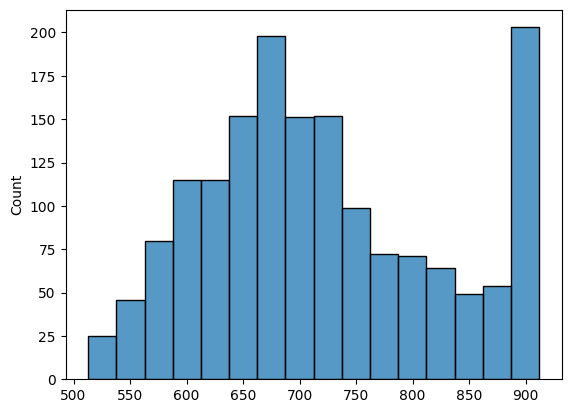

In [7]:
import seaborn as sns
length = []
for item in train_ds:
    length.append(len(item['input_ids']))
sns.histplot(data=length)

In [8]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import PaddingStrategy
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union

@dataclass
class CustomDataCollatorWithPadding:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        labels = batch["input_ids"].clone()
        
        # # Set loss mask for all pad tokens
        # labels[labels == self.tokenizer.pad_token_id] = -100
        
        # Compute loss mask for appropriate tokens only
        for i in range(batch['input_ids'].shape[0]):
            
            # Decode the training input
            text_content = self.tokenizer.decode(batch['input_ids'][i][1:])  # slicing from [1:] is important because tokenizer adds bos token
            
            # Extract substrings for prompt text in the training input
            # The training input ends at the last user msg ending in [/INST]
            prompt_gen_boundary = text_content.rfind("[/INST]") + len("[/INST]")
            prompt_text = text_content[:prompt_gen_boundary]
            
            # print(f"""PROMPT TEXT:\n{prompt_text}""")
            
            # retokenize the prompt text only
            prompt_text_tokenized = self.tokenizer(
                prompt_text,
                return_overflowing_tokens=False,
                return_length=False,
            )
            # compute index where prompt text ends in the training input
            prompt_tok_idx = len(prompt_text_tokenized['input_ids'])
            
            # Set loss mask for all tokens in prompt text
            labels[i][range(prompt_tok_idx)] = -100
            
                    
        batch["labels"] = labels
        return batch

In [9]:
max_seq_length = 1024

data_collator=CustomDataCollatorWithPadding(
    tokenizer=tokenizer, 
    padding="longest", 
    max_length=max_seq_length, 
    return_tensors="pt"
)


training_arguments = SFTConfig(
    output_dir="./tmp",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    dataset_text_field="input_ids",
    max_seq_length=1024,
    learning_rate=1e-4,
    max_steps=2500,
    warmup_ratio=0.1,
    weight_decay=0.01,
)
trainer = SFTTrainer(
    model=LMmodel,
    train_dataset=train_ds,
    tokenizer=tokenizer,
    args=training_arguments,
    # Using custom data collator inside SFTTrainer
    data_collator=data_collator
)

/home/explorer/anaconda3/envs/lasse/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:407: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [10]:
import json
def is_json(myjson):
  try:
    json.loads(myjson)
  except ValueError as e:
    return False
  return True

In [11]:


def evaluate(model, test_ds, data_collator):

    eval_df = pd.DataFrame(columns=['pred', 'label_pred', 'is_valid_json'])
    #generate response
    for input_data in tqdm(test_ds):
        res = model.generate(data_collator([input_data])['input_ids'].to(DEVICE), max_new_tokens=20)
        answ = tokenizer.decode(res[0]).split('[/INST]')[-1]
        clean_answ = re.sub('</s>', '', answ)
        is_valid_json = is_json(clean_answ)
        label = None
        if is_valid_json: 
            label = int(label_mapping(json.loads(clean_answ)['label']))
        eval_df.loc[len(eval_df)] = [clean_answ, label, is_valid_json]
    
    
    #evaluate response
    eval_df = pd.concat([test_df.loc[: len(eval_df) -1], eval_df], axis=1)
    return eval_df

def calculate_metrics(eval_df):
    valid_json = sum(eval_df['is_valid_json']) / len(eval_df)
    eval_df.dropna(inplace=True)
    macro_f1 = f1_score([int(no) for no in eval_df['label']], [int(no) for no in eval_df['label_pred']], average='macro')
    micro_f1 = f1_score([int(no) for no in eval_df['label']], [int(no) for no in eval_df['label_pred']], average='micro')
    return valid_json, micro_f1, macro_f1

        

In [12]:
eval_df = evaluate(trainer.model, test_ds, data_collator)
metric_res = calculate_metrics(eval_df)
print(metric_res)
eval_df

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

(1.0, np.float64(0.0), np.float64(0.0))


,par,label,json,pred,label_pred,is_valid_json
0,The parallel Web pages we collected from vario...,0,"{""label"": ""BACKGROUND""}","{""label"": ""USE""}",1,True
1,"However, a major obstacle to this approach is ...",0,"{""label"": ""BACKGROUND""}","{""label"": ""USE""}",1,True
2,The parallel Web pages we collected from vario...,0,"{""label"": ""BACKGROUND""}","{""label"": ""COMPARE_CONTRAST""}",2,True
3,"Beside HTML markups, other criteria may also b...",3,"{""label"": ""MOTIVATION""}","{""label"": ""FUTURE""}",5,True
4,The parallel Web pages we collected from vario...,0,"{""label"": ""BACKGROUND""}","{""label"": ""USE""}",1,True
5,The first system we have implemented with APE ...,5,"{""label"": ""FUTURE""}","{""label"": ""USE""}",1,True
6,2 See ( #AUTHOR_TAG ) for how MIMIC 's dialogu...,0,"{""label"": ""BACKGROUND""}","{""label"": ""USE""}",1,True
7,The strategies employed when MIMIC has only di...,1,"{""label"": ""USE""}","{""label"": ""COMPARE_CONTRAST""}",2,True
8,Previous work has argued that initiative affec...,0,"{""label"": ""BACKGROUND""}","{""label"": ""COMPARE_CONTRAST""}",2,True
9,Previous work has argued that initiative affec...,0,"{""label"": ""BACKGROUND""}","{""label"": ""COMPARE_CONTRAST""}",2,True


In [13]:
trainer.train()

Step,Training Loss
500,0.317900
1000,0.263600
1500,0.177800
2000,0.128300
2500,0.088800


TrainOutput(global_step=2500, training_loss=0.19527914581298828, metrics={'train_runtime': 1815.3721, 'train_samples_per_second': 1.377, 'train_steps_per_second': 1.377, 'total_flos': 7.70354066038702e+16, 'train_loss': 0.19527914581298828, 'epoch': 1.5188335358444713})

In [16]:
eval_df = evaluate(trainer.model, test_ds, data_collator)
metric_res = calculate_metrics(eval_df)
print(metric_res)
eval_df.head()

100%|██████████| 284/284 [04:21<00:00,  1.09it/s]

(1.0, np.float64(0.7676056338028169), np.float64(0.6428927883383747))


,par,label,json,pred,label_pred,is_valid_json
0,The parallel Web pages we collected from vario...,0,"{""label"": ""BACKGROUND""}","{""label"": ""BACKGROUND""}",0,True
1,"However, a major obstacle to this approach is ...",0,"{""label"": ""BACKGROUND""}","{""label"": ""BACKGROUND""}",0,True
2,The parallel Web pages we collected from vario...,0,"{""label"": ""BACKGROUND""}","{""label"": ""BACKGROUND""}",0,True
3,"Beside HTML markups, other criteria may also b...",3,"{""label"": ""MOTIVATION""}","{""label"": ""MOTIVATION""}",3,True
4,The parallel Web pages we collected from vario...,0,"{""label"": ""BACKGROUND""}","{""label"": ""BACKGROUND""}",0,True
